In [2]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

import pandas, seaborn, numpy, collections, sefara, varcode, uncertainties, numpy, statsmodels, pickle, scipy
%matplotlib inline
from matplotlib import pyplot
import topiary
import mhctools
import matplotlib_venn
import intervaltree
import statsmodels.robust
import mhcflurry
from varcode.common import memoize
pandas.set_option('display.max_columns', None)
import scipy, sys, sklearn
import sklearn.utils
import matplotlib
#import common as c
import sklearn.tree
import pymc3
from scipy import optimize
import glob


def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

matplotlib.rc("savefig", dpi=800)
#matplotlib.rc("savefig", dpi=72)
matplotlib.rc('text', usetex=False)
#reload(c)

%matplotlib inline
%config InlineBackend.figure_format = 'png'

import pystan
import pyfaidx



In [5]:
df = pandas.read_csv("../data/c_elegans_substitutions.csv")
df["context_mutation_3p5p"] = df.CONTEXT.str.slice(2, 3) + "(" + df.MUT_TYPE + ")" + df.CONTEXT.str.slice(4, 5)
df

,ID,Genotype,Drug,Concentration,CHR,POS,REF_BASE,TOP_GENOTYPE,TOP_GENOTYPE_PROB,2ND_GENOTYPE,2ND_GENOTYPE_PROB,NORM_A,NORM_C,NORM_G,NORM_T,MUT_A,MUT_C,MUT_G,MUT_T,NORM_COVERAGE,TUM_COVERAGE,MUT_TYPE,CONTEXT,GENE_FOOTPRINT,STRAND_TX,context_mutation_3p5p
0,CD0001a,N2,None,0,I,6945674,A,AA/GG,1.00,AG/GG,3.800000e-12,46,0,0,0,0,0,60,0,46,60,T>C,CTTTAAA,No_gene,No_gene,T(T>C)A
1,CD0001a,N2,None,0,II,12649008,T,TT/AT,1.00,AT/AT,1.600000e-09,0,0,0,37,25,0,0,17,37,42,T>A,TTTTAAA,No_gene,No_gene,T(T>A)A
2,CD0001a,N2,None,0,II,12770220,T,TT/GG,0.81,TT/GT,1.900000e-01,0,0,0,21,0,0,2,0,21,2,T>G,CAATACG,Y46G5A.13,Non-transcribed,A(T>G)A
3,CD0001a,N2,None,0,II,13334311,G,GG/AA,0.90,GG/AG,1.000000e-01,0,0,43,0,3,0,0,0,43,3,C>T,CTGCGTC,No_gene,No_gene,G(C>T)G
4,CD0001a,N2,None,0,II,13334507,A,AA/AG,1.00,AG/AG,8.800000e-08,31,0,0,0,15,0,6,0,31,21,T>C,TGGTGCC,No_gene,No_gene,G(T>C)G
5,CD0001a,N2,None,0,II,13334511,C,CC/AC,1.00,AC/AC,2.300000e-08,0,33,0,0,6,15,0,0,33,21,C>A,CCACTTG,No_gene,No_gene,A(C>A)T
6,CD0001a,N2,None,0,II,13334512,T,TT/GT,1.00,GT/GT,2.200000e-08,0,0,0,33,0,0,6,15,33,21,T>G,CACTTGC,No_gene,No_gene,C(T>G)T
7,CD0001a,N2,None,0,II,13334523,A,AA/AG,1.00,AG/AG,3.100000e-09,36,0,0,0,14,0,14,0,36,28,T>C,ACGTAGA,No_gene,No_gene,G(T>C)A
8,CD0001a,N2,None,0,II,13334540,T,TT/CT,1.00,CT/CT,2.100000e-10,0,0,0,40,0,17,0,10,40,27,T>C,AAATGCG,No_gene,No_gene,A(T>C)G
9,CD0001a,N2,None,0,V,18982871,C,CC/CT,1.00,CT/CT,5.700000e-11,0,42,0,0,0,29,0,20,42,49,C>T,CTGCTAA,Y39B6A.39,Non-transcribed,G(C>T)T


In [6]:
def sort_key(context):
    return (context.split(">")[0][-1],context.split(">")[1][0], context  )
all_contexts = sorted(set(df.context_mutation_3p5p), key=sort_key)


In [7]:
def normalize(series):
    return series / series.sum()


In [8]:
# C elegans genome for normalization constants
# THIS IS SLOW
import Bio, gzip
c_elegans_seq = Bio.SeqIO.parse(gzip.open("/Users/tim/sinai/git/ovarian-paired-analyses//data/original/Caenorhabditis_elegans.WBcel235.dna_sm.toplevel.fa.gz"), 'fasta')
c_elegans_seq

counts = collections.Counter()
for record in c_elegans_seq:
    for i in range(len(record.seq) - 3):
        if (i % 100000 == 0):
            print("%d / %d = %f%%" % (i, len(record.seq), i * 100.0 / len(record.seq)))
        sub = str(record.seq[i:i+3])
        if sub == sub.upper():
            counts[sub] += 1
            
def canonicalize(trinucleotide):
    (left, middle, right) = trinucleotide
    if middle in ('A', 'G'):
        return pyfaidx.complement(right) + pyfaidx.complement(middle) + pyfaidx.complement(left)
    return trinucleotide

canonicalized_counts = [(canonicalize(key), count) for (key, count) in counts.items()]
genome_counts = pandas.DataFrame(
    canonicalized_counts, columns=["context", "count"]).groupby("context")["count"].sum().to_frame()
genome_counts

0 / 15072434 = 0.000000%
100000 / 15072434 = 0.663463%
200000 / 15072434 = 1.326926%
300000 / 15072434 = 1.990389%
400000 / 15072434 = 2.653851%
500000 / 15072434 = 3.317314%
600000 / 15072434 = 3.980777%
700000 / 15072434 = 4.644240%
800000 / 15072434 = 5.307703%
900000 / 15072434 = 5.971166%
1000000 / 15072434 = 6.634628%
1100000 / 15072434 = 7.298091%
1200000 / 15072434 = 7.961554%
1300000 / 15072434 = 8.625017%
1400000 / 15072434 = 9.288480%
1500000 / 15072434 = 9.951943%
1600000 / 15072434 = 10.615406%
1700000 / 15072434 = 11.278868%
1800000 / 15072434 = 11.942331%
1900000 / 15072434 = 12.605794%
2000000 / 15072434 = 13.269257%
2100000 / 15072434 = 13.932720%
2200000 / 15072434 = 14.596183%
2300000 / 15072434 = 15.259646%
2400000 / 15072434 = 15.923108%
2500000 / 15072434 = 16.586571%
2600000 / 15072434 = 17.250034%
2700000 / 15072434 = 17.913497%
2800000 / 15072434 = 18.576960%
2900000 / 15072434 = 19.240423%
3000000 / 15072434 = 19.903885%
3100000 / 15072434 = 20.567348%
3200000

,count
context,
ACA,2811348
ACC,1351201
ACG,1287484
ACT,2361788
ATA,3223133
ATC,2553212
ATG,2644784
ATT,5578505
CCA,1986970


In [9]:
def normalize_by_counts(sub_df):
    sub_df = sub_df.to_frame()
    sub_df.columns = ['count']
    sub_df["normalization"] = [x[0] + x[2] + x[-1] for x in sub_df.index]
    sub_df["normalization_value"] = [genome_counts.ix[x]["count"] for x in sub_df.normalization]
    sub_df["raw_fraction"] = sub_df["count"] / sub_df["normalization_value"]
    sub_df["fully_normalized_fraction"] = normalize(sub_df["count"] / sub_df["normalization_value"])
    print(sub_df)
    return sub_df.fully_normalized_fraction

fractions = normalize_by_counts(
    df[(df.Genotype == "N2") & (df.Drug == "Cisplatin") & (df.Concentration > 0) ].context_mutation_3p5p.value_counts()[all_contexts].fillna(0)
)
fractions

         count normalization  normalization_value  raw_fraction  \
A(C>A)A      0           ACA              2811348  0.000000e+00   
A(C>A)C      0           ACC              1351201  0.000000e+00   
A(C>A)G      0           ACG              1287484  0.000000e+00   
A(C>A)T      1           ACT              2361788  4.234080e-07   
C(C>A)A      1           CCA              1986970  5.032789e-07   
C(C>A)C      9           CCC               889776  1.011491e-05   
C(C>A)G      0           CCG              1030576  0.000000e+00   
C(C>A)T      3           CCT              1337544  2.242917e-06   
G(C>A)A      0           GCA              1788020  0.000000e+00   
G(C>A)C      2           GCC              1013984  1.972418e-06   
G(C>A)G      0           GCG               842865  0.000000e+00   
G(C>A)T      3           GCT              1578120  1.900996e-06   
T(C>A)A      2           TCA              3442436  5.809839e-07   
T(C>A)C      3           TCC              1986048  1.510538e-0

A(C>A)A    0.000000
A(C>A)C    0.000000
A(C>A)G    0.000000
A(C>A)T    0.013418
C(C>A)A    0.015950
C(C>A)C    0.320554
C(C>A)G    0.000000
C(C>A)T    0.071081
G(C>A)A    0.000000
G(C>A)C    0.062508
G(C>A)G    0.000000
G(C>A)T    0.060245
T(C>A)A    0.018412
T(C>A)C    0.047871
T(C>A)G    0.036734
T(C>A)T    0.000000
A(C>G)A    0.000000
A(C>G)C    0.000000
A(C>G)G    0.000000
A(C>G)T    0.013418
C(C>G)A    0.000000
C(C>G)C    0.000000
C(C>G)G    0.000000
C(C>G)T    0.000000
G(C>G)A    0.000000
G(C>G)C    0.031254
G(C>G)G    0.000000
G(C>G)T    0.000000
T(C>G)A    0.000000
T(C>G)C    0.000000
             ...   
A(T>C)G    0.000000
A(T>C)T    0.000000
C(T>C)A    0.000000
C(T>C)C    0.016585
C(T>C)G    0.000000
C(T>C)T    0.011285
G(T>C)A    0.000000
G(T>C)C    0.022443
G(T>C)G    0.000000
G(T>C)T    0.000000
T(T>C)A    0.009555
T(T>C)C    0.000000
T(T>C)G    0.000000
T(T>C)T    0.003905
A(T>G)A    0.000000
A(T>G)C    0.000000
A(T>G)G    0.000000
A(T>G)T    0.000000
C(T>G)A    0.000000


In [12]:
signatures_df = pandas.read_table("../data/signatures_probabilities.txt")
signatures_df["Somatic Mutation Type"] = signatures_df["Somatic Mutation Type"].str.replace("[", "(").str.replace("]", ")")
signatures_df.index = signatures_df["Somatic Mutation Type"]
for column in signatures_df.columns:
    if 'signature' not in column.lower():
        del signatures_df[column]
signatures_df #.sum(axis=0)

,Signature 1,Signature 2,Signature 3,Signature 4,Signature 5,Signature 6,Signature 7,Signature 8,Signature 9,Signature 10,Signature 11,Signature 12,Signature 13,Signature 14,Signature 15,Signature 16,Signature 17,Signature 18,Signature 19,Signature 20,Signature 21,Signature 22,Signature 23,Signature 24,Signature 25,Signature 26,Signature 27,Signature 28,Signature 29,Signature 30
Somatic Mutation Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A(C>A)A,0.011098,6.827082e-04,0.022172,0.0365,0.014942,0.0017,0.0004,0.036718,0.0120,0.0007,0.0002,0.0077,3.347572e-04,0.0001,0.0013,0.0161,0.001832,5.053642e-02,0.0107,1.179962e-03,0.0001,0.001504,0.000453,0.028646,0.009897,2.039773e-03,0.005206,0.001397,0.069982,0.000000
A(C>A)C,0.009149,6.191072e-04,0.017872,0.0309,0.008961,0.0028,0.0005,0.033246,0.0067,0.0010,0.0010,0.0047,6.487361e-04,0.0042,0.0040,0.0097,0.000342,1.093982e-02,0.0074,2.211505e-03,0.0007,0.002451,0.000367,0.020215,0.006999,1.487162e-03,0.004738,0.000917,0.055152,0.000000
A(C>A)G,0.001490,9.927896e-05,0.002138,0.0183,0.002208,0.0005,0.0000,0.002525,0.0005,0.0003,0.0000,0.0017,3.814459e-05,0.0005,0.0000,0.0022,0.000002,2.288073e-03,0.0005,1.616910e-07,0.0000,0.000000,0.000000,0.020479,0.001448,2.839456e-04,0.000783,0.000000,0.017847,0.001967
A(C>A)T,0.006234,3.238914e-04,0.016265,0.0243,0.009207,0.0019,0.0004,0.033599,0.0068,0.0092,0.0002,0.0046,8.466585e-04,0.0296,0.0057,0.0088,0.003180,1.942409e-02,0.0074,3.008010e-03,0.0006,0.000922,0.000000,0.024600,0.004967,5.978656e-04,0.002718,0.000513,0.026805,0.000000
A(C>G)A,0.001801,2.634810e-04,0.024003,0.0097,0.011671,0.0013,0.0000,0.008357,0.0048,0.0005,0.0007,0.0031,3.775165e-03,0.0001,0.0011,0.0048,0.001662,1.516888e-03,0.0058,6.970411e-04,0.0005,0.000528,0.000000,0.011993,0.008033,1.272881e-03,0.001324,0.000255,0.009302,0.000000
A(C>G)C,0.002581,2.698660e-04,0.012160,0.0054,0.007292,0.0012,0.0000,0.004306,0.0023,0.0003,0.0003,0.0015,9.208248e-04,0.0000,0.0001,0.0024,0.001627,2.498785e-03,0.0019,2.059310e-03,0.0008,0.000000,0.000000,0.008425,0.001636,1.528195e-03,0.001771,0.000269,0.003479,0.000000
A(C>G)G,0.000593,2.192339e-04,0.005275,0.0031,0.002304,0.0000,0.0000,0.000584,0.0000,0.0000,0.0000,0.0000,1.989049e-05,0.0000,0.0006,0.0000,0.000026,2.614509e-03,0.0000,1.273496e-05,0.0000,0.000000,0.000000,0.000000,0.000000,3.072463e-04,0.000000,0.000000,0.000154,0.004820
A(C>G)T,0.002964,6.109735e-04,0.023278,0.0054,0.011696,0.0018,0.0001,0.008635,0.0038,0.0002,0.0009,0.0025,3.860632e-03,0.0001,0.0010,0.0073,0.001329,3.983011e-03,0.0072,8.485871e-04,0.0018,0.000299,0.000000,0.003881,0.003428,2.498252e-03,0.001323,0.000308,0.003977,0.000000
A(C>T)A,0.029515,7.441557e-03,0.017872,0.0120,0.021839,0.0312,0.0000,0.018067,0.0093,0.0000,0.0225,0.0121,1.480181e-03,0.0293,0.0117,0.0135,0.009350,3.825624e-03,0.0221,3.285805e-02,0.0051,0.003113,0.019767,0.006316,0.020988,5.907232e-03,0.013723,0.005434,0.005197,0.065119


In [15]:
signatures_df["Cisplatin"] = fractions
signatures_df["Cisplatin"] = signatures_df["Cisplatin"].fillna(0)

def sort_key(context):
    return (context.split(">")[0][-1],context.split(">")[1][0], context  )
signatures_df = signatures_df.ix[sorted(signatures_df.index, key=sort_key)]


signatures_df.to_csv("../data/all_signatures.csv")
signatures_for_deconstructsigs_df = signatures_df.T.copy()
signatures_for_deconstructsigs_df.columns = [
    x.replace("(", "[").replace(")", "]") for x in signatures_for_deconstructsigs_df.columns
]
signatures_for_deconstructsigs_df.to_csv("../data/all_signatures_for_deconstructsigs.csv")

signatures_df #.sum(axis=0)

,Signature 1,Signature 2,Signature 3,Signature 4,Signature 5,Signature 6,Signature 7,Signature 8,Signature 9,Signature 10,Signature 11,Signature 12,Signature 13,Signature 14,Signature 15,Signature 16,Signature 17,Signature 18,Signature 19,Signature 20,Signature 21,Signature 22,Signature 23,Signature 24,Signature 25,Signature 26,Signature 27,Signature 28,Signature 29,Signature 30,Cisplatin
Somatic Mutation Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A(C>A)A,1.109833e-02,6.827082e-04,0.022172,0.0365,0.014942,0.0017,0.0004,0.036718,0.0120,0.0007,0.0002,0.0077,3.347572e-04,0.0001,0.0013,0.0161,0.001832,5.053642e-02,0.0107,1.179962e-03,0.0001,0.001504,0.000453,0.028646,0.009897,0.002040,0.005206,0.001397,0.069982,0.000000,0.000000
A(C>A)C,9.149341e-03,6.191072e-04,0.017872,0.0309,0.008961,0.0028,0.0005,0.033246,0.0067,0.0010,0.0010,0.0047,6.487361e-04,0.0042,0.0040,0.0097,0.000342,1.093982e-02,0.0074,2.211505e-03,0.0007,0.002451,0.000367,0.020215,0.006999,0.001487,0.004738,0.000917,0.055152,0.000000,0.000000
A(C>A)G,1.490070e-03,9.927896e-05,0.002138,0.0183,0.002208,0.0005,0.0000,0.002525,0.0005,0.0003,0.0000,0.0017,3.814459e-05,0.0005,0.0000,0.0022,0.000002,2.288073e-03,0.0005,1.616910e-07,0.0000,0.000000,0.000000,0.020479,0.001448,0.000284,0.000783,0.000000,0.017847,0.001967,0.000000
A(C>A)T,6.233885e-03,3.238914e-04,0.016265,0.0243,0.009207,0.0019,0.0004,0.033599,0.0068,0.0092,0.0002,0.0046,8.466585e-04,0.0296,0.0057,0.0088,0.003180,1.942409e-02,0.0074,3.008010e-03,0.0006,0.000922,0.000000,0.024600,0.004967,0.000598,0.002718,0.000513,0.026805,0.000000,0.013418
C(C>A)A,6.595870e-03,6.774450e-04,0.018782,0.0461,0.009675,0.0101,0.0012,0.031724,0.0098,0.0031,0.0007,0.0135,1.710090e-03,0.0056,0.0106,0.0159,0.001032,8.876811e-02,0.0112,1.737711e-02,0.0020,0.004550,0.000165,0.063559,0.014833,0.003706,0.005065,0.001169,0.051410,0.000000,0.015950
C(C>A)C,7.342368e-03,2.136810e-04,0.015760,0.0614,0.004952,0.0241,0.0006,0.025505,0.0057,0.0009,0.0017,0.0112,1.159257e-03,0.0102,0.0084,0.0100,0.000422,2.064139e-02,0.0159,3.650246e-02,0.0014,0.003764,0.000737,0.033757,0.007822,0.003981,0.002234,0.000334,0.025826,0.000000,0.320554
C(C>A)G,8.928404e-04,6.770460e-06,0.001963,0.0088,0.002801,0.0091,0.0000,0.001160,0.0000,0.0007,0.0010,0.0028,2.441665e-04,0.0009,0.0015,0.0022,0.000297,1.717840e-02,0.0018,1.248259e-02,0.0027,0.000900,0.000164,0.022429,0.001277,0.000812,0.000266,0.000054,0.014496,0.002262,0.000000
C(C>A)T,7.186582e-03,4.163329e-04,0.014723,0.0432,0.011013,0.0571,0.0013,0.028791,0.0091,0.0160,0.0014,0.0071,1.256768e-03,0.1257,0.0228,0.0084,0.000031,3.767696e-02,0.0096,1.034012e-01,0.0056,0.004440,0.000723,0.020087,0.012564,0.019038,0.003101,0.000187,0.040355,0.000000,0.071081
G(C>A)A,8.232604e-03,3.520134e-04,0.009697,0.0376,0.011892,0.0024,0.0003,0.023682,0.0118,0.0014,0.0004,0.0062,1.321096e-04,0.0018,0.0024,0.0096,0.006535,1.287242e-01,0.0032,1.116124e-03,0.0001,0.001298,0.000350,0.054676,0.013465,0.001375,0.010756,0.002137,0.078047,0.008853,0.000000


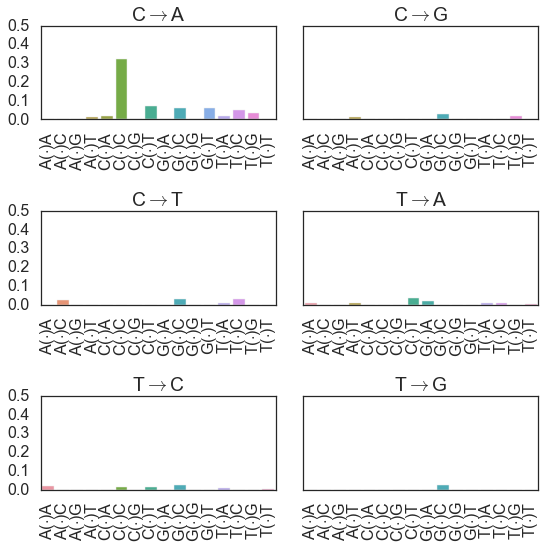

In [87]:
seaborn.set_context('poster')
seaborn.set_style("white")
pyplot.figure(figsize=(8,8))

df = signatures_df.reset_index()
grid=(3,2)
positions = []
for row in range(grid[0]):
    for col in range(grid[1]):
        positions.append((row, col))

prev_axes = []
for ((row, col), kind) in zip(positions, sorted(set(df["Somatic Mutation Type"].str.slice(2,5)))):
    sharex = sharey = None
    if col > 1:
        sharey = prev_axes[-1]
    if row != 0:
        sharex = prev_axes[-grid[1]]
        
    ax = pyplot.subplot2grid(grid, (row, col), sharex=sharex, sharey=sharey)
    prev_axes.append(ax)
    
    sub_df = df[df["Somatic Mutation Type"].str.contains(kind)]
    
    seaborn.barplot(ax=ax,
                    data=sub_df,
                    y="Cisplatin",
                    x="Somatic Mutation Type")
    pyplot.xticks(numpy.arange(sub_df.shape[0]), sub_df["Somatic Mutation Type"].str.replace("(%s)" % kind, "$\cdot$"))
    pyplot.xticks(rotation=90)
    pyplot.ylabel("")
    pyplot.xlabel("")
    pyplot.title(kind.replace(">", "$\\rightarrow$"))
    pyplot.ylim(ymin=0, ymax=0.5)
    #ax.xaxis.grid('on')
   
    #ax.label_outer()
    for label in ax.get_yticklabels():
        label.set_visible(ax.is_first_col())
        
#pyplot.suptitle("Cisplatin signature")
pyplot.tight_layout()

In [65]:
ax.label_outer??

In [63]:
ax.xaxis.grid?

In [ ]:
pandas.Series.str.